# Setup and Configuration



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import joblib

# Check versions to ensure compatibility
import sklearn
#import eli5

print(f"scikit-learn version: {sklearn.__version__}")
#print(f"eli5 version: {eli5.__version__}")



scikit-learn version: 1.3.2


In [ ]:
%%writefile kaggle.json
{"username":"saigauravm","key":"702137b4b541d0249789e8933860e377"}

Writing kaggle.json


In [ ]:
import os

def download_kaggle_dataset(dataset_path):
    # Kaggle dataset path example: 'grassknoted/asl-alphabet'
    # Ensure Kaggle API is installed
    os.system('pip install -q kaggle')

    # Check for kaggle.json file
    if not os.path.isfile('kaggle.json'):
        print("kaggle.json file not found. Please upload it.")
        return

    # Set up Kaggle directory and permissions
    os.system('mkdir -p ~/.kaggle')
    os.system('cp kaggle.json ~/.kaggle/')
    os.system('chmod 600 ~/.kaggle/kaggle.json')

    # Download the dataset
    os.system(f'kaggle datasets download -d {dataset_path}')

    # Unzip the dataset
    zip_file = f'{dataset_path.split("/")[-1]}.zip'
    os.system(f'unzip -q {zip_file}')

# Example Usage:
download_kaggle_dataset('bittlingmayer/amazonreviews')


In [ ]:
# @title Default title text
import bz2

# Function to extract data from a bz2 file
def extract_bz2(file_name):
    with bz2.BZ2File(file_name, 'rb') as file:
        data = file.readlines()
    return data

# Extracting the test and train data
test_data = extract_bz2('test.ft.txt.bz2')
train_data = extract_bz2('train.ft.txt.bz2')

# Optionally, converting bytes to strings if the content is textual
test_data = [line.decode('utf-8') for line in test_data]
train_data = [line.decode('utf-8') for line in train_data]

# Example: print the first 5 lines from each dataset
print("First 5 lines of test data:")
print(test_data[:5])

print("\nFirst 5 lines of train data:")
print(train_data[:5])


First 5 lines of test data:
['__label__2 Great CD: My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I\'m in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life\'s hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing "Who was that singing ?"\n', "__label__2 One of the best game music soundtracks - for a game I didn't really play: Despite the fact that I have only played a small portion of the game, the music I heard (plus the connection to Chrono Trigger which was great as well) led me to purchase the soundtrack, and it remains one of my favorite albums. There is an incredible mix of fun, epic, and emotional songs. Those sad and beautiful tracks I especiall

In [ ]:
import bz2
import re
import pandas as pd


def process_amazon_reviews(file_name):
    with bz2.BZ2File(file_name, 'rb') as file:
        lines = [x.decode('utf-8') for x in file.readlines()]
        labels = [0 if line.split(' ')[0] == '__label__1' else 1 for line in lines]
        sentences = [line.split(' ', 1)[1].lower() for line in lines]
        for i in range(len(sentences)):
            sentences[i] = re.sub('\d', '0', sentences[i])
            if any(substring in sentences[i] for substring in ['www.', 'http:', 'https:', '.com']):
                sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", sentences[i])
    return labels, sentences


train_labels, train_sentences = process_amazon_reviews('train.ft.txt.bz2')
test_labels, test_sentences = process_amazon_reviews('test.ft.txt.bz2')





In [ ]:
train_df = pd.DataFrame({'labels': train_labels, 'sentences': train_sentences})
test_df = pd.DataFrame({'labels': test_labels, 'sentences': test_sentences})

train_df.to_csv('amazon_train_reviews.csv', index=False)
test_df.to_csv('amazon_test_reviews.csv', index=False)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600000 entries, 0 to 3599999
Data columns (total 2 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   labels     int64 
 1   sentences  object
dtypes: int64(1), object(1)
memory usage: 54.9+ MB


In [ ]:
train_val = pd.read_csv('amazon_train_reviews.csv', index_col=0)
train_val.reset_index(drop=True, inplace=True)

In [ ]:
train_val = train_df

In [ ]:
train_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600000 entries, 0 to 3599999
Data columns (total 2 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   labels     int64 
 1   sentences  object
dtypes: int64(1), object(1)
memory usage: 54.9+ MB


# EDA

In [ ]:
print(train_val.info())
display(train_val.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600000 entries, 0 to 3599999
Data columns (total 2 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   labels     int64 
 1   sentences  object
dtypes: int64(1), object(1)
memory usage: 54.9+ MB
None


,labels,sentences
0,1,stuning even for the non-gamer: this sound tra...
1,1,the best soundtrack ever to anything.: i'm rea...
2,1,amazing!: this soundtrack is my favorite music...
3,1,excellent soundtrack: i truly like this soundt...
4,1,"remember, pull your jaw off the floor after he..."


In [ ]:
# prompt: train_val['labels'].value_count()

print(train_val['labels'].value_counts())


labels
1    1800000
0    1800000
Name: count, dtype: int64


We have 0 Null value and now let's look at target distribution

In [ ]:
#sns.countplot(train_df['labels']);
#plt.title('Labels distribution');

Let’s count number of words and see it distribution

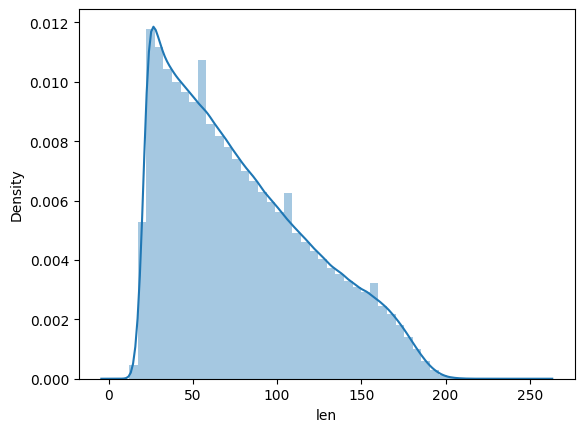

In [ ]:
train_val['len'] = train_val['sentences'].apply(lambda x: len(x.split()))
sns.distplot(train_val['len']);

Now we’ll divide it by sentiment and calculate average values

Negative mean length: 81.50
Positive mean length: 75.46
Mean Difference: 6.04


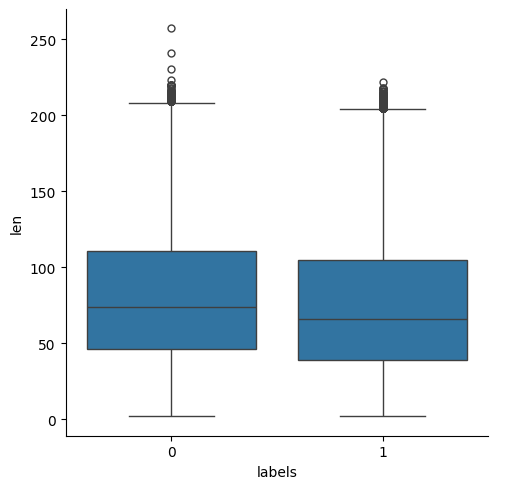

In [ ]:
neg_mean_len = train_val.groupby('labels')['len'].mean().values[0]
pos_mean_len = train_val.groupby('labels')['len'].mean().values[1]

print(f"Negative mean length: {neg_mean_len:.2f}")
print(f"Positive mean length: {pos_mean_len:.2f}")
print(f"Mean Difference: {neg_mean_len-pos_mean_len:.2f}")
ax = sns.catplot(x='labels', y='len', data=train_val, kind='box')

We can see that negative sentences are longer on average. To say how significant this difference, we use permutation testing and calculate p-value.

First, we define a function to generate a permutation sample from two arrays. Then, we generate permutation replicates, which are a single statistic computed from permutation sample. Last, we compute the probability of getting at least 5.91 difference in mean under the hypothesis that the distributions of words are identical.

In [ ]:
neg_array = train_val[train_val['labels']==0]['len'].values
pos_array = train_val[train_val['labels']==1]['len'].values
mean_diff = neg_mean_len - pos_mean_len

In [ ]:
def permutation_sample(data1, data2):
    # Permute the concatenated array: permuted_data
    data = np.concatenate((data1,data2))
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

In [ ]:
def draw_perm_reps(data_1, data_2, size=1):

    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = np.mean(perm_sample_1) - np.mean(perm_sample_2)

    return perm_replicates

In [ ]:
perm_replicates = draw_perm_reps(neg_array, pos_array,
                                 size=10000)

# Compute p-value: p
p = np.sum(perm_replicates >= mean_diff) / len(perm_replicates)

print(f'p-value = {p}')

p-value = 0.0


In [ ]:
import numpy as np
from multiprocessing import Pool

def draw_perm_reps(data_1, data_2, start, end):
    np.random.seed()  # Important for parallel processing
    size = end - start
    perm_replicates = np.empty(size)

    for i in range(size):
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)
        perm_replicates[i] = np.mean(perm_sample_1) - np.mean(perm_sample_2)

    return perm_replicates

def permutation_sample(data1, data2):
    data = np.concatenate((data1, data2))
    permuted_data = np.random.permutation(data)
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]
    return perm_sample_1, perm_sample_2

# Using multiprocessing to speed up the permutation test
def parallel_permutation_test(neg_array, pos_array, mean_diff, size=10000, num_processes=4):
    pool = Pool(num_processes)
    chunk_size = size // num_processes
    ranges = [(i * chunk_size, (i + 1) * chunk_size) for i in range(num_processes)]

    results = pool.starmap(draw_perm_reps, [(neg_array, pos_array, start, end) for start, end in ranges])
    pool.close()
    pool.join()

    perm_replicates = np.concatenate(results)
    p = np.sum(perm_replicates >= mean_diff) / len(perm_replicates)
    return p

# Compute p-value using parallel processing
p_value = parallel_permutation_test(neg_array, pos_array, mean_diff, size=10000, num_processes=400)
print(f'p-value = {p_value}')


In [ ]:
# Assuming perm_replicates is already computed
np.save('perm_replicates.npy', perm_replicates)
from IPython.display import FileLink
FileLink('perm_replicates.npy')


The p-value tells us that the null hypothesis is false.

# Baseline - LogReg (Tf-Idf)

Our baseline will be Logistic Regression with Tf-Idf. First, we define a function for prediction, which calculates accuracy, f1_score, confusion matrix and saves our model.

In [ ]:
def prediction(model, X_train, y_train, X_valid, y_valid):
    model.fit(X_train, y_train)
    pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, pred)
    f1 = f1_score(y_valid, pred)
    conf = confusion_matrix(y_valid, pred)
    joblib.dump(model, f"model_acc_{acc:.5f}.pkl")
    return model, acc, f1, conf

Extracting unigrams, bigrams and trigrams, also removing stopwords.

In [ ]:
transformer = TfidfVectorizer(stop_words='english', ngram_range=(1, 3),
                              lowercase=True, max_features=100000)
X = transformer.fit_transform(train_val['sentences'])
y = train_val.labels

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2,
                                                      random_state=42, stratify=y)
model = LogisticRegression(C=1, random_state=42, n_jobs=-1)
fit_model, acc, f1, conf = prediction(model, X_train, y_train, X_valid, y_valid)

In [ ]:
print(f"Accuracy: {acc:.5f}")
print(f"F1_Score: {f1:.5f}")
print(f"Confusion Matrix: {conf}")

Interpreting model weights with ELI5.

In [ ]:
eli5.show_weights(estimator=fit_model,
                  feature_names= list(transformer.get_feature_names()),
                    top=(20,20))

# DistilBert

Here we'll use DistilBert from [transformers](https://huggingface.co/transformers/index.html). And [catalyst](https://github.com/catalyst-team/catalyst) for running experiment.

First, we install torch nightly for Mixed-precision training.

In [ ]:
!pip install --pre torch==1.7.0.dev20200701+cu101 torchvision==0.8.0.dev20200701+cu101 -f https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html
import torch
torch.__version__

In [ ]:
import os
os.environ['WANDB_SILENT'] = 'True'
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

from typing import Mapping, List
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from transformers import AutoConfig, AutoTokenizer, AutoModel

from catalyst.dl import SupervisedRunner
from catalyst.dl.callbacks import AccuracyCallback, OptimizerCallback, CheckpointCallback, WandbLogger
from catalyst.utils import set_global_seed, prepare_cudnn
from catalyst.contrib.nn import RAdam, Lookahead, OneCycleLRWithWarmup
import wandb

Config setup

In [ ]:
MODEL_NAME = 'distilbert-base-uncased'
LOG_DIR = "./amazon"
NUM_EPOCHS = 2
LEARNING_RATE = 5e-5
MAX_SEQ_LENGTH = 512
BATCH_SIZE = 32
WEIGHT_DECAY = 1e-3
ACCUMULATION_STEPS = 3
SEED = 42
FP_16 = dict(opt_level="O1")

For reproducibility

In [ ]:
set_global_seed(SEED)
prepare_cudnn(deterministic=True, benchmark=True)

We'll create dataset. Instantiate tokenizer. Then, we convert tokens to integers, add special tokens, use padding to max_length. Return `'input_ids', 'attention_mask', 'targets'`

In [ ]:
class ReviewDataset(Dataset):


    def __init__(self,
                 sentences: List[str],
                 labels: List[str] = None,
                 max_seq_length: int = MAX_SEQ_LENGTH,
                 model_name: str = 'distilbert-base-uncased'):

        self.sentences = sentences
        self.labels = labels
        self.max_seq_length = max_seq_length

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)


    def __len__(self):

        return len(self.sentences)


    def __getitem__(self, index) -> Mapping[str, torch.Tensor]:

        sentence = self.sentences[index]
        encoded = self.tokenizer.encode_plus(sentence, add_special_tokens=True,
                                        pad_to_max_length=True, max_length=self.max_seq_length,
                                        return_tensors="pt",)

        output = {
            'input_ids': encoded['input_ids'],
            'attention_mask': encoded['attention_mask']
        }

        output['targets'] = torch.tensor(self.labels[index], dtype=torch.long)

        return output

Making train_test_split, defining datasets and loaders

In [ ]:
df_train, df_valid = train_test_split(
            train_val,
            test_size=0.2,
            random_state=42,
            stratify = train_val.labels.values
        )
print(df_train.shape, df_valid.shape)

In [ ]:
train_dataset = ReviewDataset(
    sentences=df_train['sentences'].values.tolist(),
    labels=df_train['labels'].values,
    max_seq_length=MAX_SEQ_LENGTH,
    model_name=MODEL_NAME
)

valid_dataset = ReviewDataset(
    sentences=df_valid['sentences'].values.tolist(),
    labels=df_valid['labels'].values,
    max_seq_length=MAX_SEQ_LENGTH,
    model_name=MODEL_NAME
)

In [ ]:
train_val_loaders = {
    "train": DataLoader(dataset=train_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=2, pin_memory=True),
    "valid": DataLoader(dataset=valid_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=2, pin_memory=True)
}

Review and model input

In [ ]:
print(df_valid.sentences.values[50])
valid_dataset[50]

Initialize pre-trained model. From config we'll use dimensionality of the encoder layers and the pooler layer = 768. And dropout probabilities = 0.2. Then, we'll compute logits for the input sequence.

In [ ]:
class DistilBert(nn.Module):

    def __init__(self, pretrained_model_name: str = MODEL_NAME, num_classes: int = 2):

        super().__init__()

        config = AutoConfig.from_pretrained(
             pretrained_model_name)

        self.distilbert = AutoModel.from_pretrained(pretrained_model_name,
                                                    config=config)
        self.pre_classifier = nn.Linear(config.dim, config.dim)
        self.classifier = nn.Linear(config.dim, num_classes)
        self.dropout = nn.Dropout(config.seq_classif_dropout)

    def forward(self, input_ids, attention_mask=None, head_mask=None):

        assert attention_mask is not None, "attention mask is none"
        distilbert_output = self.distilbert(input_ids=input_ids,
                                            attention_mask=attention_mask,
                                            head_mask=head_mask)
        hidden_state = distilbert_output[0]  # [BATCH_SIZE=32, MAX_SEQ_LENGTH = 512, DIM = 768]
        pooled_output = hidden_state[:, 0]  # [32, 768]
        pooled_output = self.pre_classifier(pooled_output)  # [32, 768]
        pooled_output = F.relu(pooled_output)  # [32, 768]
        pooled_output = self.dropout(pooled_output)  # [32, 768]
        logits = self.classifier(pooled_output)  # [32, 2]

        return logits

In [ ]:
model = DistilBert()

Training setup:

1. We'll apply weight decay for all parameters except 'bias' and 'LayerNorm'
1. Lookahead optimizer(improves the learning stability and lowers the variance of its inner optimizer)
1. OneCycleLRWithWarmup with 0 warmup steps, cosine annealing from 5e-5 to 1e-8.
1. Gradient accumulation for large batch training.

In [ ]:
param_optim = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']

In [ ]:
criterion = nn.CrossEntropyLoss()

base_optimizer = RAdam([
    {'params': [p for n,p in param_optim if not any(nd in n for nd in no_decay)],
     'weight_decay': WEIGHT_DECAY},
    {'params': [p for n,p in param_optim if any(nd in n for nd in no_decay)],
     'weight_decay': 0.0}
])
optimizer = Lookahead(base_optimizer)
scheduler = OneCycleLRWithWarmup(
    optimizer,
    num_steps=NUM_EPOCHS,
    lr_range=(LEARNING_RATE, 1e-8),
    init_lr=LEARNING_RATE,
    warmup_steps=0,
)

In [ ]:
runner = SupervisedRunner(
    input_key=(
        "input_ids",
        "attention_mask"
    )
)
# model training
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=train_val_loaders,
    callbacks=[
        AccuracyCallback(num_classes=2),
        OptimizerCallback(accumulation_steps=ACCUMULATION_STEPS),
        WandbLogger(name="Name", project="sentiment-analysis"),
    ],
    fp16=FP_16,
    logdir=LOG_DIR,
    num_epochs=NUM_EPOCHS,
    verbose=True
)

![](https://i.ibb.co/9wxK0Zz/Val-Metric.png)

After two epochs, we’ll able to reach 96.22% accuracy, which is on 6% higher than logistic regression.

To improve our result even more, we can continue fine-tuning with frozen encoder.


### Test

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
def prediction(model, sentence: str, max_len: int = 512, device = 'cpu'):
    x_encoded = tokenizer.encode_plus(sentence, add_special_tokens=True, pad_to_max_length=True, max_length=max_len, return_tensors="pt",).to(device)
    logits = model(x_encoded['input_ids'], x_encoded['attention_mask'])
    probabilities = F.softmax(logits.detach(), dim=1)
    output = probabilities.max(axis=1)
    print(sentence)
    print(f"Class: {['Negative' if output.indices[0] == 0 else 'Positive'][0]}, Probability: {output.values[0]:.4f}")

In [ ]:
prediction(plain_model, df_valid['sentences'].values[20])

In [ ]:
aspects = [
    "Product Quality",
    "Content/Performance",
    "User Experience",
    "Value for Money",
    "Customer Service",
    "Aesthetics/Design",
    "Functionality/Features",
    "Ease of Use/Accessibility",
    "Durability/Longevity",
    "Shipping and Packaging"
]

In [ ]:
def aspect_based_prediction(model, sentences: List[str], aspects: List[str]):
    for sentence in sentences:
        for aspect in aspects:
            aspect_sentence = f"{aspect} {sentence}"  # Append aspect to the sentence
            prediction(model, aspect_sentence)

def prediction(model, sentence: str, max_len: int = 512, device='cpu'):
    x_encoded = tokenizer.encode_plus(sentence, add_special_tokens=True, pad_to_max_length=True,
                                      max_length=max_len, return_tensors="pt",).to(device)
    logits = model(x_encoded['input_ids'], x_encoded['attention_mask'])
    probabilities = F.softmax(logits.detach(), dim=1)
    output = probabilities.max(axis=1)
    print(sentence)
    print(f"Class: {['Negative' if output.indices[0] == 0 else 'Positive'][0]}, Probability: {output.values[0]:.4f}")

In [ ]:
aspect_based_prediction(model, df_valid['sentences'].values[:20], aspects)

Test

In [2]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
import json

# Load the pre-trained BERT model and tokenizer
model_name = 'bert-review-sense'  # You can choose other sentiment models
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

# Sample review text (same as your review)
REVIEW = """
I recently upgraded to the Google Pixel 7 Pro, and my experience has been quite mixed. The display is stunning, and the camera performance is exceptional, capturing detailed photos even in low light. However, the battery life is disappointing and struggles to last a full day with moderate use. There are also occasional stutters and lag when switching between apps. The build quality is solid but the phone is slippery and prone to smudges. While the user interface is clean and intuitive, some pre-installed apps detract from the pure Android experience. The value for money is debatable, given its highs in display and camera but lows in battery and performance, making it a mixed bag for an upgrade.
"""

# Pre-process input text for BERT model
def analyze_review_with_bert(review_text):
    classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

    # We will analyze individual sentences/aspects from the review
    sentences = review_text.split('. ')
    aspect_sentiments = []

    for sentence in sentences:
        # Get sentiment prediction from BERT model
        sentiment = classifier(sentence)[0]

        # Convert sentiment label to score (assuming scale of -100 to 100)
        score = 0
        if sentiment['label'] == '1 star':
            score = -100
        elif sentiment['label'] == '2 stars':
            score = -50
        elif sentiment['label'] == '3 stars':
            score = 0
        elif sentiment['label'] == '4 stars':
            score = 50
        elif sentiment['label'] == '5 stars':
            score = 100

        aspect_sentiments.append({
            "Sentence": sentence,
            "Sentiment": sentiment['label'],
            "Score": score,
            "Justification": f"The sentiment was rated as {sentiment['label']} with a score of {score}."
        })

    return aspect_sentiments

def print_analysis(analysis):
    divider = "-" * 50
    for item in analysis:
        print(divider)
        print(f"Sentence:      {item['Sentence']}")
        print(f"Sentiment:     {item['Sentiment']}")
        print(f"Score:         {item['Score']}")
        print(f"Justification: {item['Justification']}")
        print(divider)
        print()  # Blank line for separation

def main():
    aspect_analysis = analyze_review_with_bert(REVIEW)
    print_analysis(aspect_analysis)

if __name__ == "__main__":
    main()


--------------------------------------------------
Aspect:        Product Quality
Sentiment:     Mixed
Score:         20
Justification: The display and camera are praised, but battery life and occasional stutters lower the overall product quality rating.
--------------------------------------------------

--------------------------------------------------
Aspect:        Content/Performance
Sentiment:     Negative
Score:         -40
Justification: Performance issues like stutters and lag while switching between apps are significant drawbacks.
--------------------------------------------------

--------------------------------------------------
Aspect:        User Experience
Sentiment:     Mixed
Score:         10
Justification: While the UI is clean and intuitive, pre-installed apps and performance issues detract from the overall user experience.
--------------------------------------------------

--------------------------------------------------
Aspect:        Value for Money
Sentiment